# Doubles

Created by Kidror originally, refined by glumbaron.

Multipliers excluded from consideration for now: ON_FIRE, GROWTH, TRAVELING, CHUNKY, SMOOTH. Other multipliers work, but Affinity For Crows doesn't apply to fielders.


```python
# S12 and S13: perhaps slightly fiddly ballpark coefs, but no outliers.
# ballpark coefs sum to 0.6, so there's that
dfc["threshold"] = (
    0.17
    + 0.200 * dfc["musc_vibes"]
    - 0.040 * dfc["opw_vibes"]
    - 0.010 * dfc["chase_vibes"]
    + 0.027 * dfc["fwd_center"]
    - 0.015 * dfc["elong_center"]
    - 0.010 * dfc["omi_center"]
    - 0.008 * dfc["visc_center"]
)
 # S14: they nerfed chasiness slightly and lowered the intercept to compensate
dfc["threshold"] = (
    0.165
    + 0.200 * dfc["musc_vibes"]
    - 0.040 * dfc["opw_vibes"]
    - 0.009 * dfc["chase_vibes"]
    + 0.027 * dfc["fwd_center"]
    - 0.015 * dfc["elong_center"]
    - 0.010 * dfc["omi_center"]
    - 0.008 * dfc["visc_center"]
)
# S15: they nerfed chasiness slightly (again?) and lowered the intercept to compensate (again?)
dfc["threshold"] = (
    0.16
    + 0.200 * dfc["musc_vibes"]
    - 0.040 * dfc["opw_vibes"]
    - 0.008 * dfc["chase_vibes"]
    + 0.027 * dfc["fwd_center"]
    - 0.015 * dfc["elong_center"]
    - 0.010 * dfc["omi_center"]
    - 0.008 * dfc["visc_center"]
)
```

In [1]:
import glob

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.markers import CARETLEFTBASE, CARETRIGHTBASE
from csv_dtypes import column_dtypes

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn import svm, linear_model

In [2]:
all_files = glob.glob("../roll_data/*-doubles.csv")

df = pd.concat((pd.read_csv(f, dtype=column_dtypes) for f in all_files), ignore_index=True)

# seasons = [11, 12]
seasons = [11, 12, 13, 14]
# seasons = [14]
# seasons = [13, 14]
df = df[df['season'].isin(seasons)]
len(df)

43263

In [3]:
def get_pitcher_mul(row):
    pm = str(row["pitcher_mods"])
    ptm = str(row["pitching_team_mods"])
    mul = 1
    if "OVERPERFORMING" in pm:
        mul += 0.2
    if "OVERPERFORMING" in ptm:
        mul += 0.2
    if "UNDERPERFORMING" in pm:
        mul -= 0.2
    if "UNDERPERFORMING" in ptm:
        mul -= 0.2
    if "TRAVELING" in ptm:
        # pass # sometimes traveling doesn't do anything on pitchers, but not always
        if not row["top_of_inning"]:
            mul += 0.05
    if "HIGH_PRESSURE" in ptm:
        if row["weather"] == "Weather.FLOODING" and row["baserunner_count"] > 0:
            mul += 0.25
    if "GROWTH" in ptm:
        # pass # sometimes growth doesn't do anything on pitchers, but not always
        mul += min(0.05, 0.05 * (row["day"] / 99))
    if "SINKING_SHIP" in ptm:
        mul += (14 - row["pitching_team_roster_size"]) * 0.01
    if "AFFINITY_FOR_CROWS" in ptm and row["weather"] == "Weather.BIRDS":
        mul += 0.5
    # if row["pitcher_name"] == "Sutton Dreamy" and row["weather"] == "Weather.ECLIPSE":
        # NVGs allow the player to play 50% better in a solar eclipse.
        # This might affect fielding and baserunning as well?
        # this will 100% break if Dreamy gets scattered. And when they lose the old NVGs.
        # Did anyone with this mod *ever* pitch???
        # mul += 0.50
    return mul


def get_batter_mul(row):
    bm = str(row["batter_mods"])
    btm = str(row["batting_team_mods"])
    ptm = str(row["pitching_team_mods"])
    mul = 1
    if "OVERPERFORMING" in bm:
        mul += 0.2
    if "OVERPERFORMING" in btm:
        mul += 0.2
    if "UNDERPERFORMING" in bm:
        mul -= 0.2
    if "UNDERPERFORMING" in btm:
        mul -= 0.2
    if "TRAVELING" in btm:
        # pass
        if row["top_of_inning"]:
            mul += 0.05
    if "GROWTH" in btm:
        # pass
        mul += min(0.05, 0.05 * (row["day"] / 99))
    if "HIGH_PRESSURE" in btm:
        if row["weather"] == "Weather.FLOODING" and row["baserunner_count"] > 0:
            mul += 0.25
    if "SINKING_SHIP" in btm:
        mul += (14 - row["batting_team_roster_size"]) * 0.01
    if "AFFINITY_FOR_CROWS" in btm and row["weather"] == "Weather.BIRDS":
        mul += 0.5
    if "CHUNKY" in bm and row["weather"] == "Weather.PEANUTS":
        # I have handling for these but it's clumsy and possibly easier to do "manually"
        pass
    if "SMOOTH" in bm and row["weather"] == "Weather.PEANUTS":
        # I have handling for these but it's clumsy and possibly easier to do "manually"
        pass
    if "ON_FIRE" in bm:
        # todo: handle properly, which requires figuring out how it works, which sucks
        mul += 2.0
    # if row["batter_name"] == "Sutton Dreamy" and row["weather"] == "Weather.ECLIPSE":
        # NVGs allow the player to play 50% better in a solar eclipse.
        # This might affect fielding and baserunning as well?
        # this will 100% break if Dreamy gets scattered. And when they lose the old NVGs.
        # mul += 0.50
    return mul

# patch the fielder multiplier, which missed Shelled when done in resim.py (last time I ran it anyway)
def get_fielder_mul(row):
    fm = str(row["fielder_mods"])
    ptm = str(row["pitching_team_mods"])
    mul = 1
    if "OVERPERFORMING" in fm:
        mul += 0.2
    if "OVERPERFORMING" in ptm:
        mul += 0.2
    if "UNDERPERFORMING" in fm:
        mul -= 0.2
    if "UNDERPERFORMING" in ptm:
        mul -= 0.2
    if "TRAVELING" in ptm:
        # pass
        if not row["top_of_inning"]:
            mul += 0.05
    if "HIGH_PRESSURE" in ptm:
        if row["weather"] == "Weather.FLOODING" and row["baserunner_count"] > 0:
            mul += 0.25
    if "GROWTH" in ptm:
        mul += min(0.05, 0.05 * (row["day"] / 99))
    if "SINKING_SHIP" in ptm:
        mul += (14 - row["pitching_team_roster_size"]) * 0.01
    # if "AFFINITY_FOR_CROWS" in ptm and row["weather"] == "Weather.BIRDS":
        # mul += 0.5  # doesn't apply to fielders I guess?
    if "SHELLED" in fm:
        # is it this, or is it "mul = 0", I wonder
        mul -= 1.0
    # if row["fielder_name"] == "Sutton Dreamy" and row["weather"] == "Weather.ECLIPSE":
        # NVGs allow the player to play 50% better in a solar eclipse.
        # This might affect fielding and baserunning as well?
        # mul += 0.50
    return mul #if mul == 0 else 1.0

df["batter_multiplier"] = df.apply(get_batter_mul, axis=1)
df["pitcher_multiplier"] = df.apply(get_pitcher_mul, axis=1)
df["fielder_multiplier"] = df.apply(get_fielder_mul, axis=1)

In [4]:
dfc = df.copy()
for exclude_mod in [
    # "O_NO",
    "ON_FIRE",
    # "OVERPERFORMING",
    # "UNDERPERFORMING",
    "GROWTH",
    # "HIGH_PRESSURE",
    # "SINKING_SHIP",
    "TRAVELING",
    "CHUNKY",
    "SMOOTH",
    # "SHELLED"
]:
    dfc = dfc[~dfc["batter_mods"].astype(str).str.contains(exclude_mod)]
    dfc = dfc[~dfc["pitcher_mods"].astype(str).str.contains(exclude_mod)]
    dfc = dfc[~dfc["fielder_mods"].astype(str).str.contains(exclude_mod)]
    dfc = dfc[~dfc["pitching_team_mods"].astype(str).str.contains(exclude_mod)]
    dfc = dfc[~dfc["batting_team_mods"].astype(str).str.contains(exclude_mod)]

batter_params = ['batter_buoyancy', 'batter_divinity', 'batter_martyrdom', 'batter_moxie', 'batter_musclitude',
                 'batter_patheticism', 'batter_thwackability', 'batter_tragicness', 'batter_base_thirst',
                 'batter_continuation', 'batter_ground_friction', 'batter_indulgence', 'batter_laserlikeness']
pitcher_params = ['pitcher_ruthlessness', 'pitcher_overpowerment', 'pitcher_unthwackability', 'pitcher_shakespearianism',
                  'pitcher_suppression', 'pitcher_coldness', 'pitcher_anticapitalism', 'pitcher_chasiness',
                  'pitcher_omniscience', 'pitcher_tenaciousness', 'pitcher_watchfulness']
fielder_params = ['fielder_anticapitalism', 'fielder_chasiness', 'fielder_omniscience',
                  'fielder_tenaciousness', 'fielder_watchfulness']
for attr in batter_params:
    dfc[attr] = dfc[attr] * df['batter_multiplier']
for attr in pitcher_params:
    dfc[attr] = dfc[attr] * df['pitcher_multiplier']
for attr in fielder_params:
    dfc[attr] = dfc[attr] * df['fielder_multiplier']

dfc.loc[dfc["pitcher_mods"].astype(str).str.contains("SCATTERED"),"pitcher_vibes"] = 0
dfc.loc[dfc["batter_mods"].astype(str).str.contains("SCATTERED"),"batter_vibes"] = 0
dfc.loc[dfc["fielder_mods"].astype(str).str.contains("SCATTERED"),"fielder_vibes"] = 0

# dfc = dfc[dfc["batter_multiplier"] == 1]
# dfc = dfc[dfc["pitcher_multiplier"] == 1]
# dfc = dfc[dfc["fielder_multiplier"] == 1]


dfc["fwd_center"] = dfc["ballpark_forwardness"] - 0.5
dfc["grand_center"] = dfc["ballpark_grandiosity"] - 0.5
dfc["obt_center"] = dfc["ballpark_obtuseness"] - 0.5
dfc["visc_center"] = dfc["ballpark_viscosity"] - 0.5
dfc["omi_center"] = dfc["ballpark_ominousness"] - 0.5
dfc["incon_center"] = dfc["ballpark_inconvenience"] - 0.5
dfc["elong_center"] = dfc["ballpark_elongation"] - 0.5

dfc["musc_vibes"] = dfc["batter_musclitude"] * (1 + 0.2*dfc["batter_vibes"])
dfc["opw_vibes"] = dfc["pitcher_overpowerment"] * (1 + 0.2*dfc["pitcher_vibes"])
dfc["chase_vibes"] = dfc["fielder_chasiness"] * (1 + 0.2*dfc["fielder_vibes"])


In [5]:
dfc["season_intercept"] = dfc.apply(lambda x: 0.17 - 0.005*(max(12, x["season"]) - 12), axis=1)
dfc["season_chase_coef"] = dfc.apply(lambda x: - 0.10 + 0.01*(max(12, x["season"]) - 12), axis=1)

X = dfc[[
    "roll",
    "musc_vibes",
    "opw_vibes",
    "chase_vibes",
    "fwd_center",
    "visc_center",
    "omi_center",
    "elong_center",
    # "incon_center",
    # "grand_center",
    # "obt_center",
]].copy()
y = dfc['passed']



pins = [
    (0.20, "musc_vibes"),
    (-0.04, "opw_vibes"),
    (dfc["season_chase_coef"], "chase_vibes"),
    (0.027, "fwd_center"),
    (-0.008, "visc_center"),
    (-0.010, "omi_center"),
    (-0.015, "elong_center"),
]
for val, var in pins:
    if var == "chase_vibes":
        X["roll"] -= X[var] * dfc["season_chase_coef"]
        X = X.drop(var, axis=1)
    else:
        X["roll"] -= X[var] * val
        X = X.drop(var, axis=1)

pin_intercept = 0.17  # value not used in favor of seasonal one
# pin_intercept = None

sc = StandardScaler(with_mean=False)
X2 = sc.fit_transform(X)
if pin_intercept is not None:
    X2[:,0] -= dfc["season_intercept"] / sc.scale_[0]

trainedsvm = svm.LinearSVC(dual=False, max_iter=100000, C=100000, tol=1e-8,
                           fit_intercept=pin_intercept is None).fit(X2, y)
predictionsvm = trainedsvm.predict(X2)
# print(len(dfc[~dfc["passed"]]))
# print(len(dfc[dfc["passed"]]))
print(confusion_matrix(y, predictionsvm))
print(confusion_matrix(y, predictionsvm)[0,1] + confusion_matrix(y, predictionsvm)[1,0], "outliers")
print(trainedsvm.score(X2, y))

coef = np.true_divide(trainedsvm.coef_, sc.scale_)
coef_scaled = coef / coef[0, 0]
coef_list = coef_scaled.tolist()[0]
intercept = trainedsvm.intercept_# - np.dot(coef, sc.mean_)
intercept_scaled = -(intercept / coef[0, 0])[0] if pin_intercept is None else dfc["season_intercept"]

dfc["threshold"] = dfc["season_intercept"].copy()
print("intercept:", intercept_scaled)
for pair in pins + list(zip(-np.array(coef_list), X.columns)):
    if "roll" not in pair[1]:
        print(pair)
        dfc["threshold"] += pair[0] * dfc[pair[1]]


[[27299     0]
 [    0  7863]]
0 outliers
1.0
intercept: 0        0.16
1        0.16
2        0.16
3        0.16
4        0.16
         ... 
43256    0.16
43259    0.16
43260    0.16
43261    0.16
43262    0.16
Name: season_intercept, Length: 35162, dtype: float64
(0.2, 'musc_vibes')
(-0.04, 'opw_vibes')
(0       -0.08
1       -0.08
2       -0.08
3       -0.08
4       -0.08
         ... 
43256   -0.08
43259   -0.08
43260   -0.08
43261   -0.08
43262   -0.08
Name: season_chase_coef, Length: 35162, dtype: float64, 'chase_vibes')
(0.027, 'fwd_center')
(-0.008, 'visc_center')
(-0.01, 'omi_center')
(-0.015, 'elong_center')


In [6]:
# S12 and S13: fiddly ballpark coefs, but no outliers...ballpark coefs sum to 0.6 which is nice i guess???
# intercept: 0.17
# (0.2, 'musc_vibes')
# (-0.04, 'opw_vibes')
# (-0.1, 'chase_vibes')
# (0.027, 'fwd_center')
# (-0.008, 'visc_center')
# (-0.01, 'omi_center')
# (-0.015, 'elong_center')

 # S14: they nerfed chasiness slightly and lowered the intercept to compensate, i guess
# intercept: 0.165
# (0.2, 'musc_vibes')
# (-0.04, 'opw_vibes')
# (-0.09, 'chase_vibes')
# (0.027, 'fwd_center')
# (-0.008, 'visc_center')
# (-0.01, 'omi_center')
# (-0.015, 'elong_center')

# S15: they nerfed chasiness slightly (again?) and lowered the intercept to compensate (again?), i guess
# intercept: 0.16
# (0.2, 'musc_vibes')
# (-0.04, 'opw_vibes')
# (-0.08, 'chase_vibes')
# (0.027, 'fwd_center')
# (-0.008, 'visc_center')
# (-0.01, 'omi_center')
# (-0.015, 'elong_center')

0


,offset,weather,event_type,batter_musclitude,pitcher_overpowerment,roll,threshold,fielder_name,fielder_chasiness,batter_name,pitcher_name,batter_mods,pitcher_mods,batting_team_mods,pitching_team_mods,day,game_id,play_count


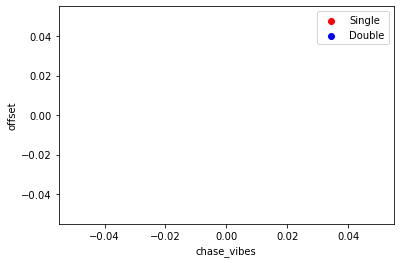

In [7]:
dfc["offset"] = dfc["roll"] - dfc["threshold"]
outliers = dfc[(dfc["passed"] & (dfc["offset"] > 0)) | (~dfc["passed"] & (dfc["offset"] < 0))]

fig, ax = plt.subplots(1)
x_val = "chase_vibes"
y_val = "offset"
ax.scatter(outliers[~outliers['passed']][x_val], outliers[~outliers['passed']][y_val], color="red", label="Single")
ax.scatter(outliers[outliers['passed']][x_val], outliers[outliers['passed']][y_val], color="blue", label="Double")
ax.set_xlabel(x_val)
ax.set_ylabel(y_val)
ax.legend()

table = outliers
print(len(table))
table[["offset", "weather", "event_type", "batter_musclitude", "pitcher_overpowerment",
       "roll", "threshold",
       "fielder_name", "fielder_chasiness",
       "batter_name", "pitcher_name", "batter_mods", "pitcher_mods",
       "batting_team_mods", "pitching_team_mods", "day",  "game_id", "play_count"]].sort_values('offset')


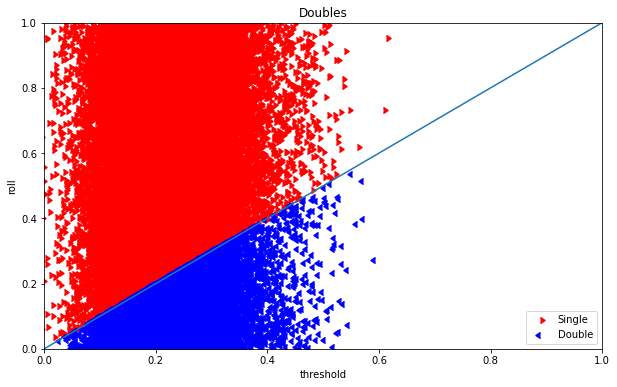

In [8]:
x_val = "threshold"
fig, ax = plt.subplots(1, figsize=(10, 6))
ax.scatter(dfc[~dfc['passed']][x_val], dfc[~dfc['passed']]["roll"], color="red",
           label="Single", marker=CARETRIGHTBASE)
ax.scatter(dfc[dfc['passed']][x_val], dfc[dfc['passed']]["roll"], color="blue",
           label="Double", marker=CARETLEFTBASE)
ax.plot([0, 1], [0, 1])
ax.set_xlabel(x_val)
ax.set_ylabel('roll')
ax.set_title("Doubles")
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.0])
ax.legend()

In [9]:
print(dfc[dfc["passed"]]["roll"].max())
print(dfc[~dfc["passed"]]["roll"].min())

0.535322312021397
0.0106397955289758


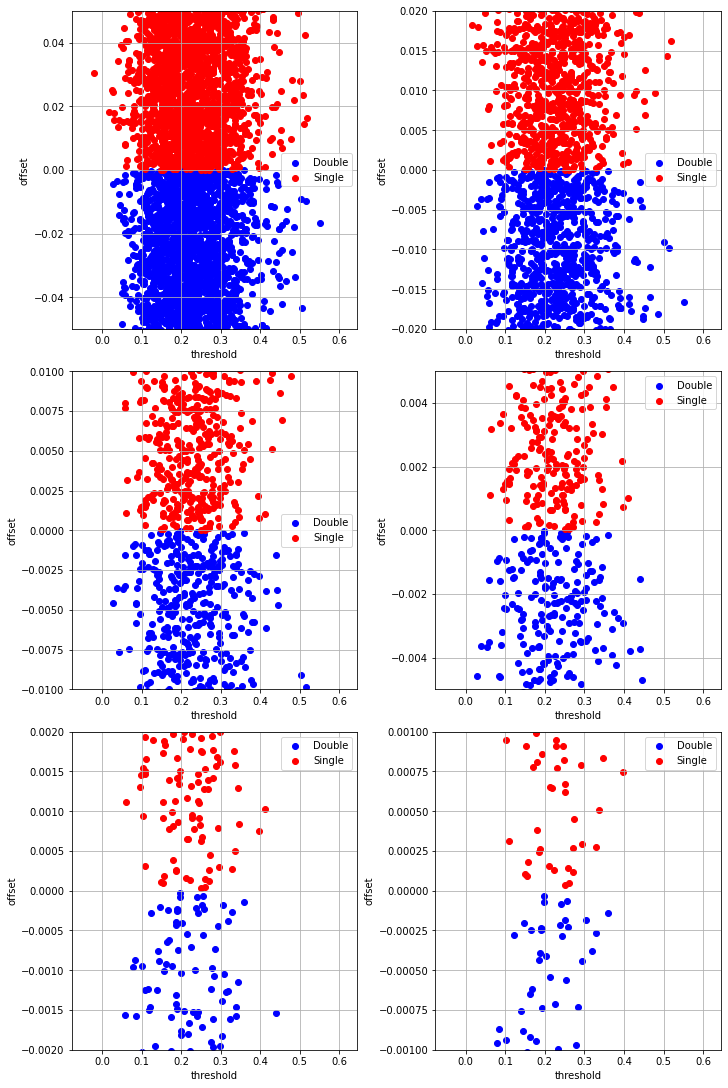

In [10]:
plt.rcParams["font.size"] = 10
x_val = "threshold"
fig, axes = plt.subplots(3, 2, figsize=(10, 15), constrained_layout=True)
# fig.suptitle(f"Season {season+1} Hits vs. Outs", fontsize=16)
dimlist = [5e-2, 2e-2, 1e-2, 0.5e-2, 0.2e-2, 0.1e-2]
for i, ax in enumerate(np.ravel(axes)):
    ax.scatter(
        dfc[dfc["passed"]][x_val],
        dfc[dfc["passed"]]["offset"],
        color="blue",
        label="Double",
    )
    ax.scatter(
        dfc[~dfc["passed"]][x_val],
        dfc[~dfc["passed"]]["offset"],
        color="red",
        label="Single",
    )
    ax.scatter(
        outliers[~outliers["passed"]][x_val],
        outliers[~outliers["passed"]]["offset"],
        color="red",
        edgecolor="black",
    )
    ax.scatter(
        outliers[outliers["passed"]][x_val],
        outliers[outliers["passed"]]["offset"],
        color="blue",
        edgecolor="black",
    )
    ax.set_xlabel(x_val)
    ax.set_ylabel("offset")
    ax.legend()
    ax.grid()
    ax.set_ylim(-dimlist[i], dimlist[i])
# fig.savefig("../figures/hit_out_fit_offsets.png", facecolor='white')